# Задание 3
- Шеверев Сергей Вячеславович
- 22М-05ММ
- Вариант *c* (3): 
    1. Промоделируем нелинейную модель с несмещенной нормально распределенной ошибкой (с заданной дисперсией)
    2. Оценим параметры нелинейной модели по методу наименьших квадратов (численной). Применим к модельным данным линейную модель и оценим параметры. Обе модели построим на двумерной диаграмме и сравним невязки.
    3. Для линейной модели выполним дисперсионный анализ, проверим значимость прогноза и коэффициентов регресси.

In [31]:
import numpy as np
np.random.seed(100)

import math 

from typing import Callable 
import functools
from matplotlib import pyplot as plt
from statistics import mode
import pandas as pd
from scipy import stats

#### Промоделируем нелинейную систему 
$$ y = f(a, x, b) + \delta $$

 - $f(x, a, b) = acos(x) + b$, где $a = 0.4$, $b = 1$
 - $\delta$ - несмещенная нормально распределенная ошибка ($D\delta = 0$)
 - $x$ - нормально распределенная случайная величина

In [48]:
a = 0.4
b=1
eps = 0.8
size= 10**6

Определим вспомогательные функции:
- `f` - нелинейная система
- `get_models_y` - функция для получения модельных данных с ошибками


In [49]:
def f(x, a, b):
    return a*np.cos(x) + b
def get_models_y(x, f, eps=eps, random_state=55):
    errors = stats.norm.rvs(loc=0, scale=np.sqrt(eps), random_state=random_state,  size=len(x))
    return np.fromiter(map(f, x), dtype='float64') + errors

func = functools.partial(f, a=a, b=b)
x_realization = stats.norm.rvs(loc=0, scale=np.sqrt(1), size=size, random_state=45)
y = get_models_y(x_realization, func, eps=eps)

#### Оценим параметры линейной модели

$$ \hat{\beta} = \frac{\sum_{i=1}^{n}{x_i y_i - n\bar{x}\bar{y}}}{\sum_{i=1}^{n}{x_i^2 - n\bar{x}^2}}\text{, } \hat{\alpha} = \bar{y} - \hat{\beta}\bar{x}$$

$$ y = \hat{\alpha} + \hat{\beta} x $$

In [50]:
def get_model_props(X, Y):
    x_mean = X.mean()
    y_mean = Y.mean()
    beta = (np.dot(X, Y) - len(X)*x_mean*y_mean)/(np.dot(X, X) - len(X)*(x_mean**2) )
    #beta=  (sum(map(lambda z: z[0]*z[1], zip(X,Y))) - len(X)*x_mean*y_mean) /\
    #(sum(map(lambda z: z**2, X)) - len(X)*x_mean*x_mean)
    alpha = y_mean - beta*x_mean
    return beta, alpha
    
linear_b, linear_a = get_model_props(x_realization, y)  
print(f"Параметры для линейной модели:\n\t alpha = {linear_a}\n\t beta = {linear_b}")

Параметры для линейной модели:
	 alpha = 1.2427305005609697
	 beta = -0.00019751165203129076


Применим линейную модель

In [51]:
linear_model = lambda x: linear_a + linear_b*x
linear_y = np.fromiter(map(linear_model, x_realization), dtype='float64')

Посчитаем источники вариации и коэффициент детерминации:


- $ Q_R = \sum_{i=1}^{n}{(\hat{y_i} - \bar{y})}^2 $ -- отколнение регрессии от среднего
- $ Q_E = \sum_{i=1}^{n}{(y_j - \hat{y_i})^2}$ -- отклонение наблюдейний от линии регрессии
- $Q_T = \sum_{i=1}^{n}{( y_i - \bar{y})^2}$ -- общий источник вариации
- $R^2 = 1 - \frac{Q_E}{Q_T} = \frac{Q_R}{Q_T} $ -- коэффициент детерминации

Причем должно выполняться равенство:
$$ Q_T = Q_R + Q_E $$

In [52]:
y_mean = y.mean()
Qt = sum((y - y_mean)**2)
Qr = sum( (linear_y - y_mean)**2 )
Qe = sum( (y - linear_y)**2 )#~ chi2(n-2)
R2 = Qr/Qt
print(f'Общий источник вариации Qt = {Qt}\
\nИсточник вариации, обусловленный регрессией Qr = {Qr}\
\nНевязка Qe = {Qe}\
\nQe + Qr = {Qr + Qe}\
\n| Qt - Qe - Qr | = {np.abs(Qt - Qe - Qr)}\
\nКоэффициент детерминации R^2 = {R2}')

Общий источник вариации Qt = 833675.0032992405
Источник вариации, обусловленный регрессией Qr = 0.03898424417245703
Невязка Qe = 833674.9643149809
Qe + Qr = 833675.0032992251
| Qt - Qe - Qr | = 1.541804952459591e-08
Коэффициент детерминации R^2 = 4.6761920434435734e-08


Равенство $ Q_T = Q_E + Q_R $ выполняется, если положить разницу $1.541803208715553e-08$ как ошибку машинного нуля. 

Вычислим квадраты стандартных ошибок коэффициентов регрессии:

In [53]:
x_mean = x_realization.mean()
xx = sum((x_realization - x_mean)**2)
S2 = Qe/(size-2)
S2alpha = S2/xx/size*sum(x_realization**2)
S2beta = S2/xx

print(f"S2 = {S2}\
\nS2_alpha = {S2alpha}\
\nS2_beta = {S2beta}")

S2 = 0.8336766316682442
S2_alpha = 8.336771410932262e-07
S2_beta = 8.342456537998734e-07


Посчитаем статистики для проверки значимости прогноза и кэффициентов регрессии:

- $ F = \frac{Q_R}{Q_E}\cdot(n-2)$
- $ T_{\alpha} = \frac{\hat{\alpha} - \alpha}{S_{\alpha}} \sim T(n-2)$
- $ T_{\beta} = \frac{\hat{\beta} - \beta}{S_{\beta}} \sim T(n-2)$

In [54]:
F = Qr/Qe*(size - 2)
Talpha = (linear_a - a)/np.sqrt(S2alpha)
Tbeta = (linear_b - b)/np.sqrt(S2beta)
Pf = 1 - stats.f.cdf(F, 1, size-2)
Pa = 2*( 1 - stats.t.cdf(np.abs(Talpha), size-2) )
Pb = 2*( 1 - stats.t.cdf(np.abs(Tbeta), size-2) )

print(f'F: {F}\nTa = {Talpha}\nTb = {Tbeta}\nPf = {Pf}\nPa = {Pa}\nPb = {Pb}')

F: 0.046761829097268656
Ta = 922.9746342386507
Tb = -1095.0622135545211
Pf = 0.8287969504222206
Pa = 0.0
Pb = 0.0


Воспользуемся встроенной в **scipy** функцией *linregress*:

In [55]:
result = stats.linregress(x_realization, y)
scipy_a = result.intercept
scipy_b = result.slope

print(f'scipy_alpha = {scipy_a} | my_alpha = {linear_a} | diff = {np.abs(scipy_a - linear_a)}')
print(f'scipy_beta = {scipy_b} | my_beta = {linear_b} | diff = {np.abs(scipy_b - linear_b)}')

scipy_alpha = 1.2427305005609697 | my_alpha = 1.2427305005609697 | diff = 0.0
scipy_beta = -0.00019751165203129063 | my_beta = -0.00019751165203129076 | diff = 1.3552527156068805e-19


Видно, что параметры линейной модели собственной реализации и библиотечной различаются на уровне машинного нуля

Теперь воспользуемся аналогом функции *nlm* (для языка R) из **scipy** minimize

In [56]:
from scipy import optimize

def L(a, b, x, y, f):
    return sum((y - f(x, a, b))**2)

func_to_optimize = lambda x: L(x[0], x[1], x_realization, y, f)

res = optimize.minimize(func_to_optimize, [scipy_a, scipy_b], args=())
nlm_a = res.x[0]
nlm_b = res.x[1]
print(f"nlm_alpha = {nlm_a} | true_alpha = {a} | diff = {np.abs(nlm_a - a)}\
\nnlm_beta={nlm_b} | true_beta = {b} | diff = {np.abs(nlm_b - b)}")

nlm_alpha = 0.4013484507348078 | true_alpha = 0.4 | diff = 0.0013484507348077712
nlm_beta=0.9991579580212278 | true_beta = 1 | diff = 0.0008420419787722455


Библиотечная функция минимизировала $ \sum_{i=1}^{n}(y_i - f(x_i, a, b))^2  $. Полученные параметры близки к истинным.

#### Вычислим невязки моделей:

In [57]:
def Q(y, pred_y):
    return sum((y - pred_y)**2)

scipy_optim_y = np.array([f(i, nlm_a, nlm_b) for i in x_realization])

Q_linear = Q(y, linear_y)
Q_scipy = Q(y, scipy_optim_y)
Q_orig = Q(y, np.array([f(i, a, b) for i in x_realization]))

In [58]:
Q_linear


833674.9643149809

In [59]:
Q_scipy

801490.5155924753

In [60]:
Q_orig

801490.880381224

Видно, что невязка линейной модели несколько больше невязки нелинейных моделей:
 - **Q_linear** - невязка линейной модели
 - **Q_scipy** - невязка нелинейной модели, параметры который были оценены численно
 - **Q_orig**  - невязка нелинейной модели из уловий

### Построим двумерную диаграмму:

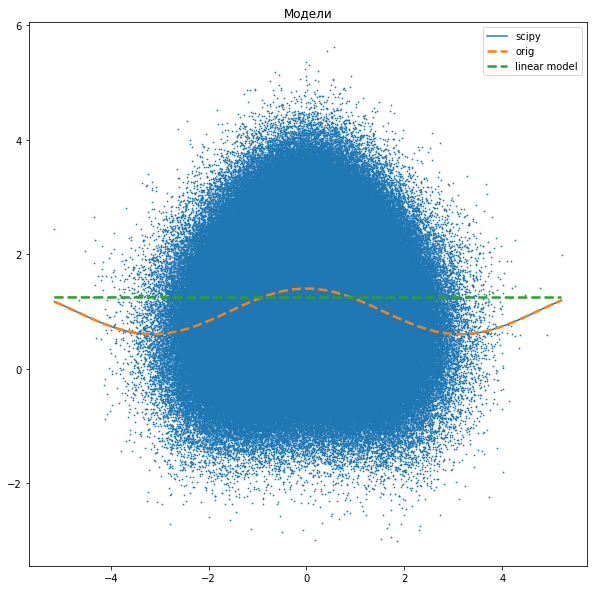

In [61]:
plt.figure().set_size_inches(10, 10)
plt.title('Модели')
plt.scatter(x_realization, y, s=0.53)
left = x_realization.min()
right = x_realization.max()
space = np.linspace(left, right)
#disc
plt.plot(space, [f(i, nlm_a, nlm_b) for i in space], label="scipy", linewidth=1.5)
plt.plot(space, [f(i, a, b) for i in space], label="orig", linewidth=2.5, linestyle= '--')
plt.plot(space, [linear_a + linear_b*i for i in space], label="linear model", linewidth=2.5, linestyle= '--')

plt.legend()
plt.show()

Точками на диаграмме изображены данные промоделированной нелинейной модели с ошибками. 
 - Зеленым цветом изображена линейная модель
 - Синим цветом изображена  нелинейная модель, параметры которой были оценены численно 
 - Оранжевым цветом изображена нелинейная модель

Можно увидеть, что графики нелинейных моделей совпадают.